In [1]:
#Benjamin Blankartz
#data source: https://www.kaggle.com/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis
# source env/bin/activate

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl 
print(skl.__version__)
pd.set_option('max_columns', None)

0.24.1


In [3]:
df = pd.read_csv('./data/DataCoSupplyChainDataset.csv',delimiter=',')
print(df.shape)

(180519, 53)


In [4]:
df.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajast�n,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajast�n,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [6]:
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,-84.915675,6691.379495,36221.894903,692.509764,20.664741,0.101668,90260.000000,141.232550,0.120647,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,21.433241,4162.918106,21045.379569,336.446807,21.800901,0.070415,52111.490959,139.732492,0.466796,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025986,1.000000,1.000000,19.000000,0.000000,0.000000,1.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,-98.446312,3258.500000,18057.000000,403.000000,5.400000,0.040000,45130.500000,50.000000,0.080000,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,-76.847908,6457.000000,36140.000000,627.000000,14.000000,0.100000,90260.000000,59.990002,0.270000,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,-66.370583,9779.000000,54144.000000,1004.000000,29.990000,0.160000,135389.500000,199.990005,0.360000,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,115.263077,20757.000000,77204.000000,1363.000000,500.000000,0.250000,180519.000000,1999.989990,0.500000,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


In [7]:
corr = df.corr()


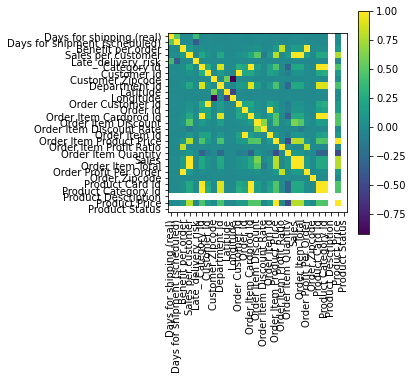

In [8]:
corr = df.corr()
corrPlot = plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrPlot)
plt.show()

In [9]:
#drop columns with ID in name to simplify 
df_noID = df[df.columns.drop(list(df.filter(regex=' Id')))]
df_noID.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,13.110000,0.04,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,16.389999,0.05,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajast�n,PENDING,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,18.030001,0.06,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajast�n,CLOSED,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,22.940001,0.07,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,29.500000,0.09,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


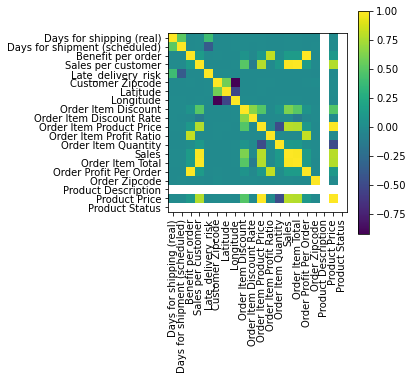

In [10]:
corr_no_ID = df_noID.corr()
corrPlot = plt.matshow(corr_no_ID )
plt.xticks(range(len(corr_no_ID .columns)), corr_no_ID .columns, rotation=90)
plt.yticks(range(len(corr_no_ID .columns)), corr_no_ID .columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrPlot)
plt.show()

/home/benjamin/Documents/DataScience/SmartSupplyChain/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


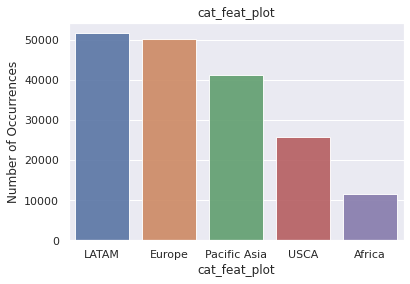

In [11]:
#Explore the catagorical features
cat_feat_plot = 'Market'
import seaborn as sns
import matplotlib.pyplot as plt
count = df_noID[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

/home/benjamin/Documents/DataScience/SmartSupplyChain/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


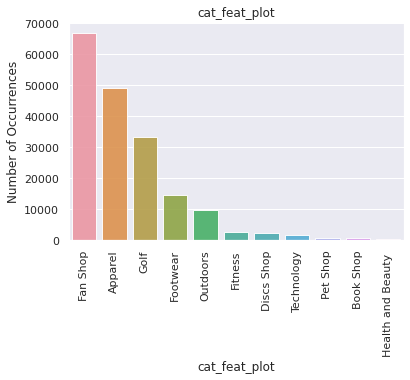

In [12]:
#Explore the catagorical features
cat_feat_plot = 'Department Name'
import seaborn as sns
import matplotlib.pyplot as plt
count = df_noID[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

In [13]:
#Feature creation- benefit?
df['Value_Loss'] = np.where(df['Benefit per order'] < 0,1,0)
df['Value_Loss'].describe()
#need to do class balancing
#imb learn

count    180519.000000
mean          0.187149
std           0.390032
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Value_Loss, dtype: float64

In [14]:
#build a model to predict the benifit per order based on location data
model_data = df[['Days for shipping (real)','Customer Country','Customer State','Customer Street','Customer Zipcode','Latitude','Longitude','Market','Value_Loss','Order Status','Order Region','Order State']]
model_data.head()
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Days for shipping (real)  180519 non-null  int64  
 1   Customer Country          180519 non-null  object 
 2   Customer State            180519 non-null  object 
 3   Customer Street           180519 non-null  object 
 4   Customer Zipcode          180516 non-null  float64
 5   Latitude                  180519 non-null  float64
 6   Longitude                 180519 non-null  float64
 7   Market                    180519 non-null  object 
 8   Value_Loss                180519 non-null  int64  
 9   Order Status              180519 non-null  object 
 10  Order Region              180519 non-null  object 
 11  Order State               180519 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 16.5+ MB


In [15]:
import sklearn as skl
import sklearn.model_selection as mskl

In [16]:
model_data.dropna(inplace=True)
indices_to_keep = ~model_data.isin([np.nan, np.inf, -np.inf]).any(1)
model_data = model_data[indices_to_keep]
#tar_column = 'Benefit per order'
tar_column = 'Value_Loss'
y = model_data['Value_Loss']
X = model_data.drop(columns=['Value_Loss'])
#need to fix catagories
X_cat = X[['Customer Country','Customer State','Customer Street','Market']]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#le.fit_transform(y_cat)
X_cat = X_cat.apply(le.fit_transform)
X.update(X_cat)
X.head()
X = X.reset_index()
#np.any(np.isnan(X))
#X.info()

<ipython-input-16-b09d27526141>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace=True)


In [17]:
from sklearn.preprocessing import LabelEncoder

model_data.dropna(inplace=True)
indices_to_keep = ~model_data.isin([np.nan, np.inf, -np.inf]).any(1)
model_data = model_data[indices_to_keep]
#tar_column = 'Benefit per order'
tar_column = 'Value_Loss'
y = model_data['Value_Loss']
X = model_data.drop(columns=['Value_Loss'])
#need to fix catagories
#X = pd.get_dummies(X,drop_first=True)

le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == "object":
        encode = LabelEncoder()
        X[col] = encode.fit_transform(X[col])

#Label Encoding could be creating a signal via ordinal numbers

from sklearn.preprocessing import LabelEncoder
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180516 entries, 0 to 180518
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Days for shipping (real)  180516 non-null  int64  
 1   Customer Country          180516 non-null  int64  
 2   Customer State            180516 non-null  int64  
 3   Customer Street           180516 non-null  int64  
 4   Customer Zipcode          180516 non-null  float64
 5   Latitude                  180516 non-null  float64
 6   Longitude                 180516 non-null  float64
 7   Market                    180516 non-null  int64  
 8   Order Status              180516 non-null  int64  
 9   Order Region              180516 non-null  int64  
 10  Order State               180516 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 16.5 MB


In [18]:
X_train, X_test, y_train, y_test = mskl.train_test_split(X, y, test_size=0.33, random_state=1)


In [19]:
from sklearn.ensemble import RandomForestRegressor
#regr = RandomForestRegressor(random_state=0,n_jobs=6,max_depth = 12)
#regr.fit(X_train,y_train)

from sklearn.ensemble import RandomForestClassifier
regc = RandomForestClassifier(random_state=0,n_jobs=6,max_depth = 12)
regc.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, n_jobs=6, random_state=0)

In [21]:
#print(regr.score(X_test,y_test))
print(regc.score(X_test,y_test))

0.8151785264642192


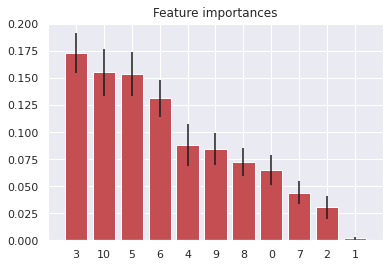

In [59]:
#tie these back in
importances = regc.feature_importances_
std = np.std([tree.feature_importances_ for tree in regc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [49]:
#Obviously customer location does not indicate order benefit
#Customer location gives little insight into real shipping times

In [ ]:
#Optimize
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters)
clf.fit(, iris.target)

regc = RandomForestClassifier(random_state=0,n_jobs=6,max_depth = 12)
regc.fit(X_train,y_train)

In [ ]:
#validate 
#confusion matrix
#specificity?
#recall?
#Calculate loss value over month
#optimize for misses

#regularization - removing unimportant features

#always circle back to real world importance